# Correspondence of precursor emissions to ozone forcing

In AR6, we do not separate tropospheric and stratospheric ozone.

Coefficients provided by AerChemMIP models contributing to Thornhill et al. 2020, and historical time series from Skeie et al. 2020.

Once this is tuned, update FaIR (may need 1.6.2 release)

In [1]:
import fair
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from fair.constants import molwt
from fair.forcing.ozone_tr import stevenson
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

## Tropospheric ozone

Follow Skeie et al., 2020 exclusively for the historical (1850-2010)

In [2]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data_input/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
#skeie_trop.insert(0, 1750, -0.03)
#skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
#skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
#skeie_trop = skeie_trop + 0.03

In [3]:
skeie_trop

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.05020,0.06650,0.07970,0.1030,0.14860,0.2012,0.2367,0.2643,0.3086,0.3347,0.3404,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.04420,0.05930,0.08410,0.1003,0.14520,0.1939,0.2350,0.2822,0.3318,0.3518,0.3711,NaN,NaN,NaN
GFDL-ESM4,0.0,0.05220,0.06250,0.08600,0.1096,0.16210,0.2113,0.2463,0.2733,0.3116,0.3280,0.3392,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.04930,0.06740,0.07670,0.1137,0.14790,0.1850,0.2209,0.2684,0.3266,0.3593,0.3660,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.05700,0.07230,0.08570,0.1096,0.15920,0.2159,0.2661,0.3122,0.3320,0.3397,0.3448,NaN,NaN,NaN
OsloCTM3,0.0,0.08204,0.09376,0.10548,0.1172,0.17065,0.2241,0.2777,0.3173,0.3527,0.3987,0.4047,0.4209,0.4117,0.4274


In [4]:
skeie_strat = pd.read_csv('../data_input/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.00760,0.0092,0.01430,0.0239,0.03590,0.0496,0.0367,0.0085,0.0147,0.0189,0.0207,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.02020,0.0221,0.04000,0.0346,0.04460,0.0533,0.0530,0.0282,0.0468,0.0456,0.0578,NaN,NaN,NaN
GFDL-ESM4,0.0,0.01380,0.0126,0.02260,0.0315,0.03600,0.0331,0.0145,-0.0397,-0.0209,-0.0206,-0.0170,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.01820,0.0122,-0.00030,0.0248,0.02330,0.0321,0.0913,0.1171,0.0737,0.0776,0.0898,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.00720,0.0144,0.01230,0.0198,0.03200,0.0570,0.0668,0.0618,0.0474,0.0403,0.0411,NaN,NaN,NaN
OsloCTM3,0.0,0.02485,0.0284,0.03195,0.0355,0.04535,0.0552,0.0710,0.0819,0.0876,0.1102,0.1198,0.1318,0.1294,0.1359


In [5]:
skeie_total = skeie_trop + skeie_strat
skeie_total.drop([2014,2017,2020], inplace=True, axis=1)
skeie_total

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010
Model,,,,,,,,,,,,
BCC-ESM1,0.0,0.05780,0.07570,0.09400,0.1269,0.1845,0.2508,0.2734,0.2728,0.3233,0.3536,0.3611
CESM2(WACCM6),0.0,0.06440,0.08140,0.12410,0.1349,0.1898,0.2472,0.2880,0.3104,0.3786,0.3974,0.4289
GFDL-ESM4,0.0,0.06600,0.07510,0.10860,0.1411,0.1981,0.2444,0.2608,0.2336,0.2907,0.3074,0.3222
GISS-E2-1-H,0.0,0.06750,0.07960,0.07640,0.1385,0.1712,0.2171,0.3122,0.3855,0.4003,0.4369,0.4558
MRI-ESM2-0,0.0,0.06420,0.08670,0.09800,0.1294,0.1912,0.2729,0.3329,0.3740,0.3794,0.3800,0.3859
OsloCTM3,0.0,0.10689,0.12216,0.13743,0.1527,0.2160,0.2793,0.3487,0.3992,0.4403,0.5089,0.5245


In [6]:
skeie_total.loc[:,2010].mean()

0.41306666666666664

2014-1850 ozone ERF from Skeie: 0.4339999999999999


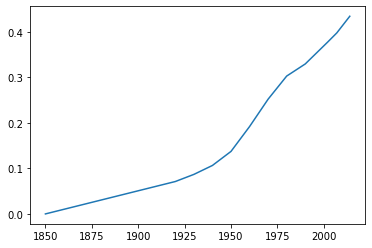

In [7]:
f = interp1d(skeie_total.columns, skeie_total.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1850,2015)
o3tr = f(years)
pl.plot(years, o3tr)
print("2014-1850 ozone ERF from Skeie:", o3tr[-1])

Thornhill et al (2020) contributions to 2014-1850 ozone forcing: 

|species  | best  | unc    |
|---------|-------|--------|
|CH4      | +0.14 | (0.05) |
|NOx      | +0.20 | (0.11) |
|CO + VOC | +0.11 | (0.07) |
|N2O      | +0.03 | (0.02) |
|ODS      | -0.11 | (0.10) |  
|Sum      | +0.37 | (0.18) |

Uncertainties, in brackets, taken to be 5-95%.

How do we define ODS here? Perhaps revert back to the Velders EESC definition.

In [8]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

scenario = 'historical'
ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1850':'2014'].values.squeeze()
n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1850':'2014'].values.squeeze()
ods = {}
ods_species = [
    'CCl4',
    'CFC11',
    'CFC113',
    'CFC114',
    'CFC115',
    'CFC12',
    'CH2Cl2',
    'CH3Br',
    'CH3CCl3',
    'CH3Cl',
    'CHCl3',
    'HCFC141b',
    'HCFC142b',
    'HCFC22',
    'Halon1211',
    'Halon1301',
    'Halon2402',
]
for specie in ods_species:
    ods[specie] = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|%s' % specie)),'1850':'2014'].values.squeeze()

co  = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|CO')),'1850':'2014'].values.squeeze()
nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|NOx')),'1850':'2014'].values.squeeze()
voc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|VOC')),'1850':'2014'].values.squeeze()

In [9]:
cl_atoms = {
    'CCl4': 4,
    'CFC11': 3,
    'CFC113': 3,
    'CFC114': 2,
    'CFC115': 1,
    'CFC12': 2,
    'CH2Cl2': 2,
    'CH3Br': 0,
    'CH3CCl3': 3,
    'CH3Cl': 1,
    'CHCl3': 3,
    'HCFC141b': 2,
    'HCFC142b': 1,
    'HCFC22': 1,
    'Halon1211': 0,
    'Halon1301': 0,
    'Halon2402': 0,
}

br_atoms = {
    'CCl4': 0,
    'CFC11': 0,
    'CFC113': 0,
    'CFC114': 0,
    'CFC115': 0,
    'CFC12': 0,
    'CH2Cl2': 0,
    'CH3Br': 1,
    'CH3CCl3': 0,
    'CH3Cl': 0,
    'CHCl3': 0,
    'HCFC141b': 0,
    'HCFC142b': 0,
    'HCFC22': 0,
    'Halon1211': 1,
    'Halon1301': 1,
    'Halon2402': 2,
}


# References:
# Daniel, J. and Velders, G.: A focus on information and options for 
#   policymakers, in: Scientific Assessment of Ozone Depletion, WMO, 2011
# Newman et al., 2007: A new formulation of equivalent effective stratospheric
#   chlorine (EESC)

fracrel = {
    'CCl4': 0.56,
    'CFC11': 0.47,
    'CFC113': 0.29,
    'CFC114': 0.12,
    'CFC115': 0.04,
    'CFC12': 0.23,
    'CH2Cl2': 0, # no literature value available
    'CH3Br': 0.60,
    'CH3CCl3': 0.67,
    'CH3Cl': 0.44,
    'CHCl3': 0, # no literature value available
    'HCFC141b': 0.34,
    'HCFC142b': 0.17,
    'HCFC22': 0.13,
    'Halon1211': 0.62,
    'Halon1301': 0.28,
    'Halon2402': 0.65,
}

In [10]:
def eesc(specie):
    return (
        (
            cl_atoms[specie] * (ods[specie]-ods[specie][0]) * fracrel[specie]/fracrel['CFC11']
        ) + 45 *
        (
            br_atoms[specie] * (ods[specie]-ods[specie][0]) * fracrel[specie]/fracrel['CFC11'])
    ) * fracrel['CFC11']

In [11]:
eesc_total = np.zeros((165))
for specie in ods_species:
    eesc_total = eesc_total + eesc(specie)

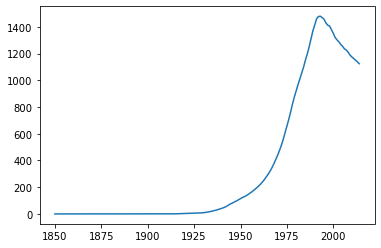

In [12]:
pl.plot(np.arange(1850,2015), eesc_total)

In [13]:
delta_Cch4 = ch4[164] - ch4[0]
delta_Cn2o = n2o[164] - n2o[0]
delta_Cods = eesc_total[164] - eesc_total[0]
delta_Eco  = co[164] - co[0]
delta_Evoc = voc[164] - voc[0]
delta_Enox = nox[164] - nox[0]

In [14]:
# best estimate radiative efficienices from 2014 - 1850

radeff_ch4 = 0.14/delta_Cch4
radeff_nox = 0.20/delta_Enox
radeff_co  = 0.067/delta_Eco    # stevenson rescaled
radeff_voc = 0.043/delta_Evoc   # stevenson rescaled
radeff_n2o = 0.03/delta_Cn2o
radeff_ods = -0.11/delta_Cods

In [15]:
fac_cmip6_skeie = (
    (
    radeff_ch4 * delta_Cch4 +
    radeff_n2o * delta_Cn2o +
    radeff_ods * delta_Cods +
    radeff_co  * delta_Eco +
    radeff_voc * delta_Evoc +
    radeff_nox * delta_Enox 
    ) / (o3tr[164]-o3tr[0])
)
ts = np.vstack((ch4, n2o, eesc_total, co, nox, voc)).T

In [16]:
ts

array([[ 8.08249029e+02,  2.73021047e+02,  0.00000000e+00,
         4.11462874e+02,  1.34565768e+01,  6.67830488e+01],
       [ 8.08414108e+02,  2.73094050e+02,  0.00000000e+00,
         4.02244815e+02,  1.31724399e+01,  6.49500466e+01],
       [ 8.09163132e+02,  2.73168050e+02,  0.00000000e+00,
         3.97498520e+02,  1.30018193e+01,  6.39578999e+01],
       [ 8.10404058e+02,  2.73264051e+02,  0.00000000e+00,
         4.00338804e+02,  1.30342532e+01,  6.44455542e+01],
       [ 8.11732142e+02,  2.73363050e+02,  0.00000000e+00,
         4.13399132e+02,  1.34219901e+01,  6.67946952e+01],
       [ 8.13332036e+02,  2.73470050e+02,  0.00000000e+00,
         4.08110454e+02,  1.33736513e+01,  6.56515640e+01],
       [ 8.14796122e+02,  2.73578046e+02,  0.00000000e+00,
         4.04854917e+02,  1.29461467e+01,  6.50425347e+01],
       [ 8.16452118e+02,  2.73675049e+02,  0.00000000e+00,
         4.14673192e+02,  1.36609981e+01,  6.67277988e+01],
       [ 8.18355128e+02,  2.73756050e+02,  0.000

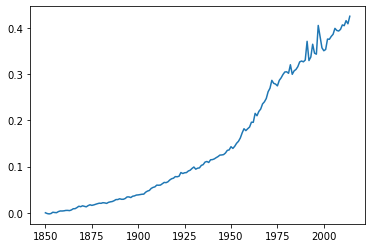

In [17]:
def fit_precursors(x, rch4, rn2o, rods, rco, rvoc, rnox):
    return rch4*x[0] + rn2o*x[1] + rods*x[2] + rco*x[3] + rvoc*x[4] + rnox*x[5]

p, cov = curve_fit(
    fit_precursors, 
    ts.T - ts[0:1, :].T,
    o3tr,
    bounds=((0.09/delta_Cch4/fac_cmip6_skeie, 0.01/delta_Cn2o/fac_cmip6_skeie, -0.21/delta_Cods/fac_cmip6_skeie, 0.017/delta_Eco/fac_cmip6_skeie, -0.007/delta_Evoc/fac_cmip6_skeie, 0.09/delta_Enox/fac_cmip6_skeie),
            (0.19/delta_Cch4/fac_cmip6_skeie, 0.05/delta_Cn2o/fac_cmip6_skeie, -0.01/delta_Cods/fac_cmip6_skeie, 0.117/delta_Eco/fac_cmip6_skeie, 0.093/delta_Evoc/fac_cmip6_skeie, 0.31/delta_Enox/fac_cmip6_skeie))
)

forcing = (
    p[0] * (ch4 - ch4[0]) +
    p[1] * (n2o - n2o[0]) +
    p[2] * (eesc_total - eesc_total[0]) +
    p[3] * (co  - co[0]) +
    p[4] * (nox  - nox[0])+
    p[5] * (voc  - voc[0])
)

pl.plot(np.arange(1850,2015), forcing)

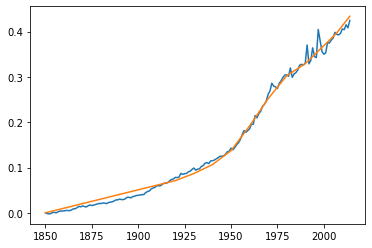

In [18]:
pl.plot(np.arange(1850,2015), forcing)
pl.plot(np.arange(1850,2015), o3tr)

In [19]:
print(p)  # these coefficients we export to the ERF time series
print(radeff_ch4, radeff_n2o, radeff_ods, radeff_co, radeff_voc, radeff_nox)

[ 2.10282063e-04  1.08675132e-03 -4.89518172e-05  3.60859411e-05
  4.37066480e-04  7.42473334e-04]
0.00013682270725101268 0.0005558958422888328 -9.787056469289512e-05 0.00012124837094765557 0.0002578827109376753 0.001406631507469693


## extrapolate back to 1750

In [20]:
ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2014'].values.squeeze()
n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2014'].values.squeeze()
ods = {}
ods_species = [
    'CCl4',
    'CFC11',
    'CFC113',
    'CFC114',
    'CFC115',
    'CFC12',
    'CH2Cl2',
    'CH3Br',
    'CH3CCl3',
    'CH3Cl',
    'CHCl3',
    'HCFC141b',
    'HCFC142b',
    'HCFC22',
    'Halon1211',
    'Halon1301',
    'Halon2402',
]
for specie in ods_species:
    ods[specie] = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|%s' % specie)),'1750':'2014'].values.squeeze()

co  = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|CO')),'1750':'2014'].values.squeeze()
nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|NOx')),'1750':'2014'].values.squeeze()
voc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|VOC')),'1750':'2014'].values.squeeze()

eesc_total = np.zeros((265))
for specie in ods_species:
    eesc_total = eesc_total + eesc(specie)

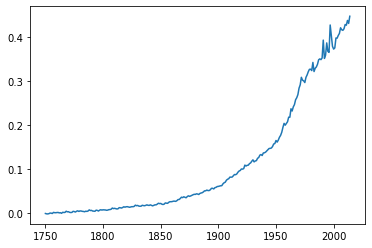

In [21]:
forcing = (
    p[0] * (ch4 - ch4[0]) +
    p[1] * (n2o - n2o[0]) +
    p[2] * (eesc_total - eesc_total[0]) +
    p[3] * (co  - co[0]) +
    p[4] * (nox  - nox[0])+
    p[5] * (voc  - voc[0])
)

pl.plot(np.arange(1750,2015), forcing)

In [22]:
forcing[264]

0.44752926289635675